In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.constants import c, k_B, M_sun, G, m_p, sigma_sb, m_p
import astropy.units as u
from scipy.sparse import csr_matrix
from scipy.optimize import fsolve, differential_evolution, minimize
import numpy as np
import numba
import sys

sys.path.append('../Numerical_methods')
from bachelor_funcs import Σ_initial
from matrix_calculator import A_matrix

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}
mpl.rc('font', **font)

In [2]:
N = 300
r_in = 0.01 # AU
r_out = 1e4 # AU 
r = np.logspace(np.log(r_in), np.log(r_out), N, base = np.exp(1))
r_au = r * u.au
r_log = np.log(r)
Δr_log = r_log[1] - r_log[0]

### Temperature bith viscous heating and stellar irradiation
$$T^4 = T_{vis}^4 + T_{req}^4$$
$$T_{req}=T_{1au}\left(\frac{r}{1au}\right)^p$$

Text(0.5, 0, 'Distance from star [AU]')

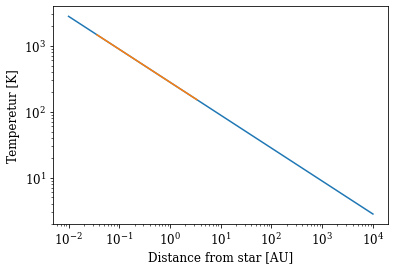

In [4]:
T_1au = 280 * u.K
p = -1/2

T_req = T_1au * (r)**p
plt.loglog(r, T_req)
plt.loglog(r[np.where((T_req >= 150 * u.K) & (T_req <= 1500 * u.K))], T_req[np.where((T_req >= 150 * u.K) & (T_req <= 1500 * u.K))])
plt.ylabel('Temperetur [K]')
plt.xlabel('Distance from star [AU]')

Text(0.5, 0, 'Distance from star [AU]')

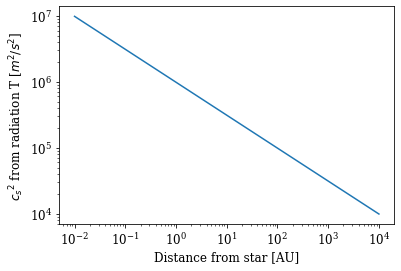

In [5]:
def c_s2(T):
    μ = 2.34
    return ((k_B * T) / (μ * m_p)).decompose()

plt.loglog(r, c_s2(T_req)) 
c_s2(T_req).unit, T_req.unit
plt.ylabel('${c_s}^2$ from radiation T [$m^2/s^2$]')
plt.xlabel('Distance from star [AU]')

### Temperature at midplane for MRI-active PPDs
$$T_{vis}^4 = \frac{1}{2\sigma_{SB}}\left(\frac{3}{8}\tau_R+\frac{1}{3\tau_P}\right)F_{rad}$$
$$\tau_R=\kappa_R\Sigma/2$$
### $\kappa_R:$
$$\kappa_R = 4.5(T/150K)^2\;cm^2g^{-1}\quad T<150K$$
$$\kappa_R = 4.5\;cm^2g^{-1}\quad 150K \leq T \leq1500K$$
$$\kappa_R = 0\;cm^2g^{-1}\quad 1500K<T$$

$$\tau_P = max(2.4\tau_R,\;0.5)$$
### $F_{rad}$ for the weak DW case (p. 4 Suzuki)
$$F_{rad} = \epsilon_{rad}\left[\frac{3}{2}\Omega\Sigmaα_{rφ}c_s^2 + r\Omegaα_{\phi z}(\rho c_s^2)_{mid}\right],\quad\epsilon_{rad}=0.9$$
$$\Sigma \Omega=\sqrt{2 \pi}(\rho c_s)_{mid}\quad \Rightarrow \quad (\rho c_s)_{mid}=\frac{1}{\sqrt{2 \pi}}\Sigma \Omega
\quad ?\;\Rightarrow\quad (\rho c_s^2)_{mid} = \frac{c_s}{\sqrt{2 \pi}}\Sigma \Omega$$
$$\frac{g}{cm^2}\frac{1}{s} = \frac{kg}{m^3}\frac{m}{s}$$ 

